# Import Libraries

In [1]:
import random
import time

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

colab_root = "/content/drive/MyDrive/my_google_colab/"

Mounted at /content/drive


In [3]:
work_dir = f"{colab_root}NLP/text_summarization/"

In [4]:
def cm_percent(y_labels, model_test_y, title = None, predicted_label = True):
    confusion_matrix = metrics.confusion_matrix(y_labels, model_test_y)

    unique_labels = list(set(y_labels))
    class_names = [None for x in range(len(unique_labels))]
    counts=[0 for x in range(len(unique_labels))]

    for y in y_labels:

      for u in range(len(unique_labels)):
        if y == unique_labels[u]:
          counts[u] = counts[u] + 1

    sums = confusion_matrix.sum(axis = 1)

    for i in range(len(class_names)):
      for c in range(len(counts)):
        if sums[i] == counts[c]:
          class_names[i] = unique_labels[c]

    if (title is None):
      if (predicted_label):
        title = "Confusion Matrix (Percent of Predicted Label)"
      else:
        title = "Confusion Matrix (Percent of True Label)"

    if (predicted_label):
        cm_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=0)[np.newaxis, :] * 100
    else:
        cm_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_percent)

    cm_display.plot(cmap='Blues', colorbar=False)

    class_labels = class_names

    plt.xticks(ticks=np.arange(len(cm_percent)), labels = class_labels)
    plt.yticks(ticks=np.arange(len(cm_percent)), labels = class_labels)

    plt.title(title)
    plt.show()

# Load Data & Balance Train Set


In [5]:
X_train = np.load(f"{work_dir}data/X_train.npy")
Y_train = np.load(f"{work_dir}data/Y_train.npy")

X_test = np.load(f"{work_dir}data/X_test.npy")
Y_test = np.load(f"{work_dir}data/Y_test.npy")

print(f"X_train: {X_train.shape}; Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}; Y_test: {Y_test.shape}")

X_train: (8751, 768); Y_train: (8751,)
X_test: (2403, 768); Y_test: (2403,)


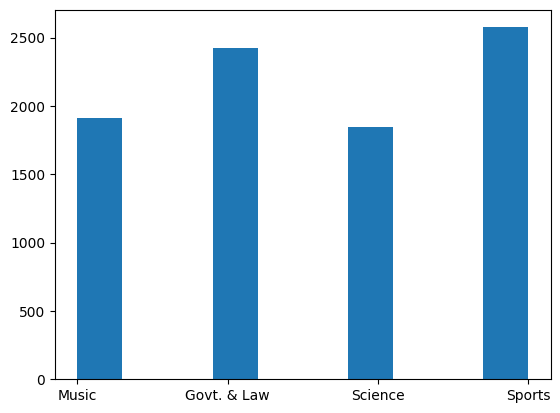

In [6]:
plt.hist(Y_train)
plt.show()

In [7]:
def balance_classes(X, Y):

  min_count = len(Y)+1
  new_X = []
  new_Y = []

  count_dict = dict()
  for y in set(Y):

    if (sum(Y==y) < min_count): min_count = sum(Y==y)
    count_dict[y] = 0

  for i in range(len(Y)):

    if (count_dict[Y[i]] < min_count):
      new_X += [X[i]]
      new_Y += [Y[i]]

      count_dict[Y[i]] = count_dict[Y[i]] + 1

  return np.array(new_X), np.array(new_Y)

In [8]:
balance_the_classes = input("Balance classes: ")

Balance classes: yes


Balanced classes.

X_train: (7372, 768); Y_train: (7372,)
X_test: (2403, 768); Y_test: (2403,)



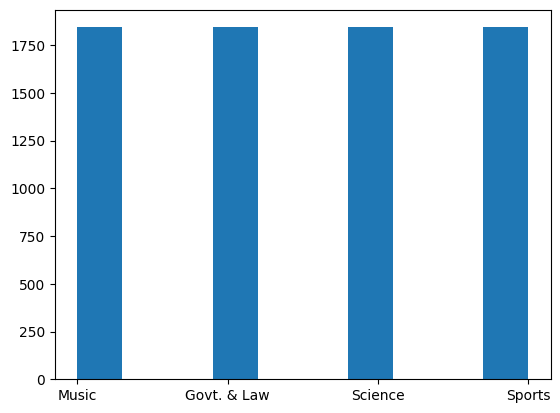

In [9]:
if (balance_the_classes == "Yes" or balance_the_classes == "yes" or balance_the_classes == "Y" or balance_the_classes == "y"):

  X_train, Y_train = balance_classes(X_train, Y_train)

  print("Balanced classes.\n")

  print(f"X_train: {X_train.shape}; Y_train: {Y_train.shape}")
  print(f"X_test: {X_test.shape}; Y_test: {Y_test.shape}\n")

  plt.hist(Y_train)
  plt.show()

# Classification

In [10]:
if (len(X_test.shape) > 2):

  X_train = np.array ( torch.flatten( torch.tensor(X_train), start_dim = 1))
  X_test = np.array ( torch.flatten( torch.tensor(X_test), start_dim = 1))

  print("Flattened arrays.\n")

print(f"X_train: {X_train.shape}; Y_train: {Y_train.shape}")
print(f" X_test: {X_test.shape};  Y_test: {Y_test.shape}")

X_train: (7372, 768); Y_train: (7372,)
 X_test: (2403, 768);  Y_test: (2403,)


In [18]:
rf = RandomForestClassifier(n_estimators = 75,
                            criterion = 'gini',
                            min_samples_split=2,
                            min_samples_leaf=3,
                            n_jobs=-1,
                            random_state=18,
                            class_weight = None
                            )

nb = GaussianNB()

SVM = svm.SVC(kernel='poly',
              decision_function_shape='ovo')


stacking_model = StackingClassifier(

    estimators=[
        # ('svm', SVM)
        ('rf', rf)
        ],

    final_estimator=SVM,
    passthrough=True
)

In [19]:
clf = stacking_model

clf.fit(X_train, Y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(min_samples_leaf=3,
                                                       n_estimators=75,
                                                       n_jobs=-1,
                                                       random_state=18))],
                   final_estimator=SVC(decision_function_shape='ovo',
                                       kernel='poly'),
                   passthrough=True)

In [20]:
pred_labels = clf.predict(X_test)

Overall Accuracy: 93.54%



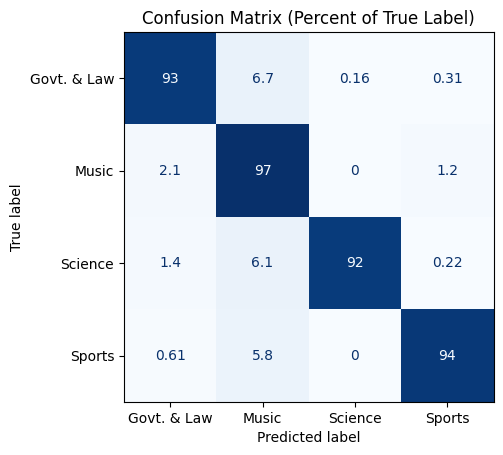

In [21]:
accuracy = accuracy_score(Y_test, pred_labels)
print(f"Overall Accuracy: {str(accuracy*100)[:5]}%\n")

cm_percent(Y_test,
           pred_labels,
           title = None,
           predicted_label = False)

In [22]:
metrics.confusion_matrix(Y_test, pred_labels)

array([[594,  43,   1,   2],
       [ 11, 503,   0,   6],
       [ 13,  56, 842,   2],
       [  2,  19,   0, 309]])

# Save Classifier


In [23]:
save_model = input("Save model: ")

Save model: yes


In [24]:
if (save_model == "yes" or save_model == "Yes" or save_model == "y" or save_model == "Y"):
  from joblib import dump
  dump(clf, f'{work_dir}models/clf.joblib')

  print(f"Successfully saved model to \n{work_dir}models/")

else:
  print("Did not save model.")

Successfully saved model to 
/content/drive/MyDrive/my_google_colab/NLP/text_summarization/models/
